In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


import ncut_loss
import build_Unet
import build_Wnet
import getData

from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

from getData import get_generator
import tensorflow_addons as tfa

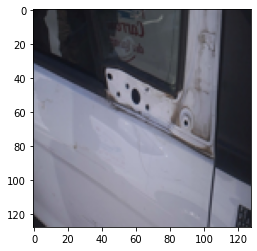

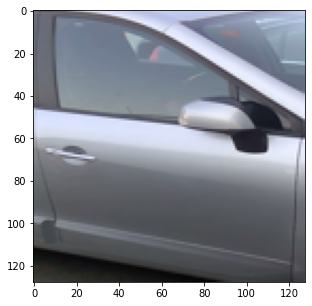

In [3]:
# DATASETS

TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_4.json"]


damaged_generator = get_generator(TEST_DATASET,1,128,damaged=True)
non_damaged_generator = get_generator(TEST_DATASET,1,128,damaged=False)

dam = damaged_generator.__getitem__(np.random.randint(1,1000))
plt.imshow((dam[0]+1)/2)


no_dam = non_damaged_generator.__getitem__(np.random.randint(1,1000))
plt.figure(figsize=(5,5))
plt.imshow((no_dam[0]+1)/2)

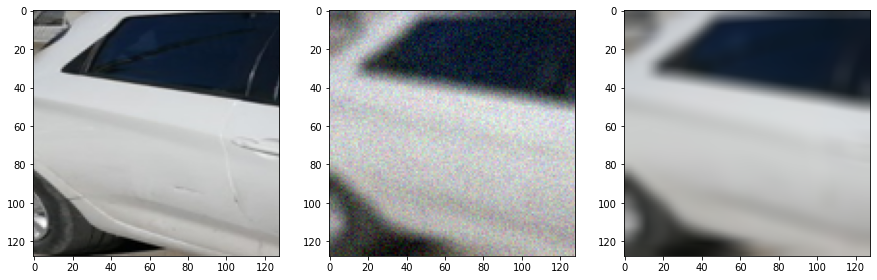

In [16]:
image = damaged_generator.__getitem__(np.random.randint(1,1000))

image_blurred = tfa.image.gaussian_filter2d( image,(10,10),5)


noise = np.random.normal(0, .1, image.shape)

image_o_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)

image_blurred = image_blurred + noise
image_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)


plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow((image[0]+1)/2)
plt.subplot(1,3,2)
plt.imshow((image_blurred[0]+1)/2)
plt.subplot(1,3,3)
plt.imshow((image_o_blurred[0]+1)/2)

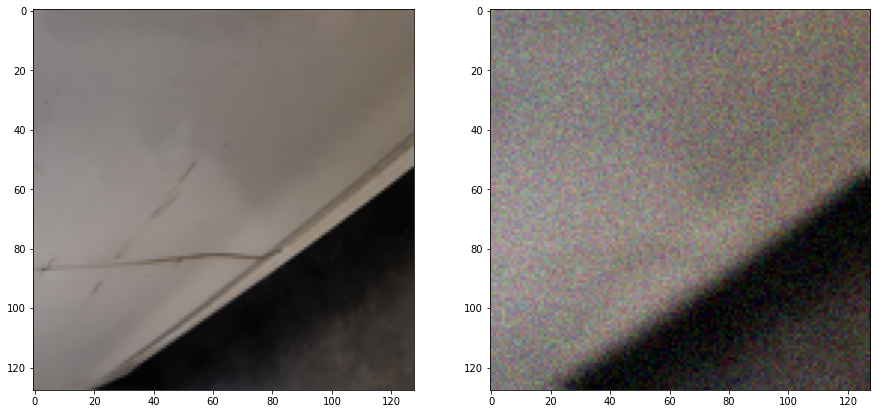

In [25]:
image = damaged_generator.__getitem__(5)

sigma=5
blur_kernel=10
noise_amp=0.1

image_blurred = tfa.image.gaussian_filter2d( image,(blur_kernel,blur_kernel),sigma)
noise = np.random.normal(0, noise_amp, image.shape)
image_blurred = image_blurred + noise
image_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow((image[0]+1)/2)
plt.subplot(1,2,2)
plt.imshow((image_blurred[0]+1)/2)



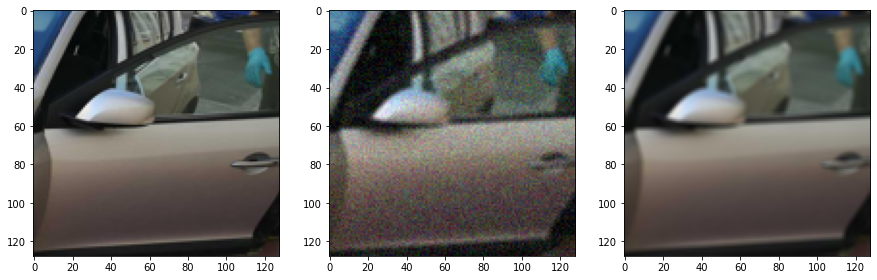

In [13]:
image = non_damaged_generator.__getitem__(3)

image_blurred = tfa.image.gaussian_filter2d( image,(3,3),10)


noise = np.random.normal(0, .1, image.shape)

image_o_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)

image_blurred = image_blurred + noise
image_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)


plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow((image[0]+1)/2)
plt.subplot(1,3,2)
plt.imshow((image_blurred[0]+1)/2)
plt.subplot(1,3,3)
plt.imshow((image_o_blurred[0]+1)/2)